# Kantar  
**Auteurs** :  
- Samy Hadj-Said  
- Jason Perez  

---

# Contexte et plan

Dans ce notebook, nous allons réaliser pas à pas les différentes étapes demandées dans le sujet :

**Sujet :**  
1. **Clustering**  
   - 1.1. Clusterisation des 5000 individus en utilisant les variables **A9, A10, A11** (en orange)  
   - 1.2. Clusterisation des 5000 individus en utilisant les variables **A11, A12, A13, A14, A4, A5, A5bis, A8_1_slice, A8_2_slice, A8_3_slice, A8_4_slice, B1_1_slice, B1_2_slice, B2_1_slice, B2_2_slice, B3, B4, B6, C1_1_slice, C1_2_slice, C1_3_slice, C1_4_slice, C1_5_slice, C1_6_slice, C1_7_slice, C1_8_slice, C1_9_slice** (en vert).  
   - Justifier les méthodes de clusterisation, expliquer le choix du nombre de groupes, et calculer le ratio de variance intra/inter.  
   - Présenter brièvement le descriptif de chaque cluster.  

2. **Réaffectation des individus dans les groupes avec variables *actives* (Golden Questions)**  
   - À partir des variables ayant servi au clustering, construire un algorithme de réaffectation (apprentissage/test).  
   - Minimiser le nombre de variables tout en maximisant le % de bon classement.  

3. **Réaffectation des individus dans les groupes avec variables *illustratives***  
   - Pour **chaque** clusterisation (Orange et Vert), réaffecter les individus :  
     - Soit avec les variables de l’autre groupe (par exemple, pour Orange, utiliser les variables Vert, et vice-versa).  
     - Soit avec les variables suivantes :  
       `rs3, rs5, rs6, RS1, RS191, RS192, RS193, RS102RECAP, rs11recap2, RS11recap, RS193bis, RS2Recap, RS56Recap, RS2, RS11, RS102`  
   - Déterminer la capacité de classification (pourcentage de bonne affectation) dans les 4 cas possibles.  

Dans ce notebook, nous allons :  
- **(Q1)** Faire deux segmentations (une pour les variables en **orange** A9, A10, A11 ; une pour les variables en **vert**).  
- **(Q2)** Proposer un algorithme de réaffectation basé sur un nombre réduit de variables *actives* (golden questions).  
- **(Q3)** Proposer un algorithme de réaffectation utilisant les *variables illustratives*.  

---

# 1. Clustering

---

## 1.1. Clustering avec les variables en ORANGE (A9, A10, A11)

### 1.1.1. Imports et chargement de la donnée

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch, KMeans, AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.ticker as mtick
import seaborn as sns
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning import Trainer
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
set_config(transform_output = "pandas")

# Remplacement de XGBoost par régression linéaire
from sklearn.linear_model import LogisticRegression, LinearRegression


In [6]:
DATA_PATH = ""
data = pd.read_csv('fic_epita_kantar_codes.csv', sep=';')

In [7]:
print(f"Les données sont composées de {data.shape[0]} lignes et {data.shape[1]} colonnes.")


Les données sont composées de 5000 lignes et 133 colonnes.


## 1.1.2. Sélection et préparation des variables ORANGE

Selon l’énoncé, les variables en ORANGE sont : A9, A10, A11.

Remarque : Dans le fichier variables_fichier.xlsx, on peut avoir des sous-variables ou des variables “slice” (A9_1_slice, A9_2_slice, etc.). Pour simplifier, on part du principe que toutes les colonnes liées à A9, A10, A11 (ex: A9_1_slice, A10_2_slice, A11_5_slice…) sont incluses dans le clustering.

In [74]:
# Colonnes génériques à supprimer
bases_exclusions = ["Respondent_ID", "weight"]

# Colonnes liées aux questions vertes
green_questions = bases_exclusions + [
    "A11", "A12", "A13", "A14", "A4", "A5", "A5bis",
    "A8_1_slice", "A8_2_slice", "A8_3_slice", "A8_4_slice",
    "B1_1_slice", "B1_2_slice", "B2_1_slice", "B2_2_slice",
    "B3", "B4", "B6",
    "C1_1_slice", "C1_2_slice", "C1_3_slice", "C1_4_slice",
    "C1_5_slice", "C1_6_slice", "C1_7_slice", "C1_8_slice", "C1_9_slice"
]

# Colonnes liées aux questions oranges
orange_questions = bases_exclusions + [
    "A9_1_slice", "A9_2_slice", "A9_3_slice", "A9_4_slice", "A9_5_slice",
    "A9_6_slice", "A9_7_slice", "A9_8_slice", "A9_9_slice", "A9_10_slice",
    "A9_11_slice", "A9_12_slice", "A9_13_slice", "A9_14_slice", "A9_15_slice",
    "A9_16_slice", "A10_1_slice", "A10_2_slice", "A10_3_slice", "A10_4_slice",
    "A10_5_slice", "A10_6_slice", "A10_7_slice", "A10_8_slice",
    "A11_1_slice", "A11_2_slice", "A11_3_slice", "A11_4_slice",
    "A11_5_slice", "A11_6_slice", "A11_7_slice", "A11_8_slice",
    "A11_9_slice", "A11_10_slice", "A11_11_slice", "A11_12_slice", "A11_13_slice"
]

# Colonnes socio-démographiques
demographic_columns = [
    "rs3", "rs5", "rs6", "RS1", "RS191", "RS192", "RS193",
    "RS102RECAP", "rs11recap2", "RS11recap", "RS193bis",
    "RS2Recap", "RS56Recap", "RS2", "RS11", "RS102"
]

# Extraction des données
green_data = data[green_questions].copy()
orange_data = data[orange_questions].copy()
demographic_data = data[demographic_columns].copy()

respondents_green = green_data["Respondent_ID"]
weights_green = green_data["weight"]
green_data = green_data.drop(bases_exclusions, axis=1)

respondents_orange = orange_data["Respondent_ID"]
weights_orange = orange_data["weight"]
orange_data = orange_data.drop(bases_exclusions, axis=1)

   A11  A12  A13  A14  A4   A5  A5bis  A8_1_slice  A8_2_slice  A8_3_slice  \
0    1    0    0    0   1  2.0    NaN           2           2           2   
1    1    0    0    0   1  5.0    NaN           2           0           0   
2    1    0    0    0   1  2.0    NaN           5           5           1   
3    1    1    1    0   1  1.0    NaN           2           3           2   
4    0    1    0    0   2  NaN    1.0           1           1           1   

   ...  B6  C1_1_slice  C1_2_slice  C1_3_slice  C1_4_slice  C1_5_slice  \
0  ...   3           2           2           2           2           2   
1  ...   3           4           4           4           4           4   
2  ...   4           4           4           4           4           4   
3  ...   4           4           4           5           5           5   
4  ...   3           4           4           4           4           4   

   C1_6_slice  C1_7_slice  C1_8_slice  C1_9_slice  
0           2           2           2   

### Explication :
	
    •	Nous scindons le dataset en plusieurs sous-ensembles :
	•	data_verts : pour les variables “en vert”.
	•	data_oranges : pour les variables “en orange”.
	•	data_socio_demographical : pour les variables socio (ex: rs3, rs5, etc.).
	•	On supprime (drop) les colonnes “Respondent_ID” et “weight” de ces dataframes car elles ne doivent pas entrer dans le clustering directement.
	•	On conserve cependant respondents_verts, weights_verts, etc., si besoin d’analyser par la suite.

## (1) - Fonction de prétraitement (One-Hot + StandardScaler)

#### Afin de préparer les données pour le clustering, nous:
	1.	Convertissons (éventuellement) les variables catégorielles en variables indicatrices (via OneHotEncoder).
	2.	Standardisons (via StandardScaler) pour éviter qu’une variable à grande échelle ne domine la distance.

In [76]:
def transform_dataset(
    input_data, 
    selected_columns, 
    excluded_columns=["Respondent_ID", "weight"]
):
    """
    Transforme un jeu de données en préparant pour le machine learning
    
    Args:
        input_data (pd.DataFrame): Jeu de données original
        selected_columns (list): Colonnes à sélectionner
        excluded_columns (list): Colonnes à supprimer
    
    Returns:
        tuple: Données transformées, identifiants répondants
    """
    data_local = input_data[selected_columns].copy()
    respondents = data_local["Respondent_ID"]
    weights = data_local["weight"]
    data_local = data_local.drop(excluded_columns, axis=1)

    ohe = OneHotEncoder(sparse_output=False)
    data_enc = ohe.fit_transform(data_local)

    data_weighted = data_enc

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_weighted)
    return pd.DataFrame(data_scaled), respondents

# Transformations des différents jeux de données
dataset_orange, ids_orange = transform_dataset(data, orange_questions)
dataset_green, ids_green = transform_dataset(data, green_questions)
dataset_green_socio, ids_green_socio = transform_dataset(data, green_questions + demographic_columns)
dataset_orange_socio, ids_orange_socio = transform_dataset(data, orange_questions + demographic_columns)

### Explication sur la sortie :
	•	data_orange_processed : dataset transformé (One-Hot + StandardScaler) ne contenant que les variables A9, A10, A11 (toutes leurs slices).
	•	data_vert_processed : dataset transformé pour A11, A12, A13, A14, etc.
	•	data_vert_socio_processed et data_orange_socio_processed : ajouts des variables socio.

### (1) - PCA & Fonctions Utilitaires

Nous appliquons une PCA pour réduire la dimension à 2 ou 3 composantes principales afin de visualiser et de faciliter le clustering.
Nous définissons aussi quelques fonctions pratiques : plot_3D, compute_silhouette_score, get_clusters_repartition.



In [77]:
def execute_dimensionality_reduction(
    data_matrix, 
    n_components=3, 
    clustering_method=KMeans, 
    n_clusters=6
):
    """
    Réduction de dimensionnalité et clustering
    
    Args:
        data_matrix (np.array): Matrice de données
        n_components (int): Nombre de composantes principales
        clustering_method (object): Algorithme de clustering
        n_clusters (int): Nombre de clusters
    
    Returns:
        tuple: Données PCA, labels de clustering, modèle PCA
    """
    pca_transformer = PCA(n_components=n_components)
    data_pca = pca_transformer.fit_transform(data_matrix)
    
    clusterer = clustering_method(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = clusterer.fit_predict(data_pca)
    
    return pd.DataFrame(data_pca), cluster_labels, pca_transformer

def evaluate_clustering(data_matrix, title_prefix):
    """
    Compare différents algorithmes de clustering
    
    Args:
        data_matrix (pd.DataFrame): Données à clustériser
        title_prefix (str): Préfixe pour les titres des graphiques
    """
    clustering_methods = {
        "BIRCH": Birch(n_clusters=6, threshold=0.5, branching_factor=100),
        "Agglomeratif": AgglomerativeClustering(n_clusters=6),
        "KMeans": KMeans(n_clusters=6, random_state=42, n_init='auto')
    }
    
    results = {}
    
    for name, method in clustering_methods.items():
        labels = method.fit_predict(data_matrix) if hasattr(method, 'fit_predict') else method.fit(data_matrix).labels_
        
        score = silhouette_score(data_matrix, labels)
        cluster_distribution = dict(zip(*np.unique(labels, return_counts=True)))
        
        results[name] = {
            'labels': labels,
            'silhouette_score': score,
            'cluster_distribution': cluster_distribution
        }
        
        print(f"## {name} sur {title_prefix}")
        print(f"Silhouette Score: {score}")
        print(f"Distribution des clusters : {cluster_distribution}\n")
    
    return results



def visualize_clusters_3d(pca_data, labels, title):
    """Visualisation 3D des clusters"""
    import plotly.graph_objects as go
    
    fig = go.Figure(data=[go.Scatter3d(
        x=pca_data.iloc[:,0],
        y=pca_data.iloc[:,1],
        z=pca_data.iloc[:,2],
        mode='markers',
        marker=dict(
            size=4,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        )
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        )
    )
    
    fig.show()

## (1) - Clustering sur les variables_orange
Dans ce bloc, nous appliquons :

	•	Une PCA sur les données oranges (A9, A10, A11).
	•	Différents algorithmes de clustering (Birch, AgglomerativeClustering, KMeans) avec un nombre de clusters fixé à 6 (à titre d’exemple).
	
    •	Nous regardons la silhouette pour chaque algorithme et la répartition des clusters.

In [78]:
def evaluate_clustering(data_matrix, title_prefix):
    """
    Compare différents algorithmes de clustering
    
    Args:
        data_matrix (pd.DataFrame): Données à clustériser
        title_prefix (str): Préfixe pour les titres des graphiques
    """
    clustering_methods = {
        "BIRCH": Birch(n_clusters=6, threshold=0.5, branching_factor=100),
        "Agglomeratif": AgglomerativeClustering(n_clusters=6),
        "KMeans": KMeans(n_clusters=6, random_state=42, n_init='auto')
    }
    
    results = {}
    
    for name, method in clustering_methods.items():
        labels = method.fit_predict(data_matrix) if hasattr(method, 'fit_predict') else method.fit(data_matrix).labels_
        
        score = silhouette_score(data_matrix, labels)
        cluster_distribution = dict(zip(*np.unique(labels, return_counts=True)))
        
        results[name] = {
            'labels': labels,
            'silhouette_score': score,
            'cluster_distribution': cluster_distribution
        }
        
        print(f"## {name} sur {title_prefix}")
        print(f"Silhouette Score: {score}")
        print(f"Distribution des clusters : {cluster_distribution}\n")
    
    return results


In [65]:
# Analyse pour les données oranges
orange_pca, orange_labels, orange_pca_model = execute_dimensionality_reduction(dataset_orange)

# Visualisations
visualize_clusters_3d(orange_pca, orange_labels, "Clusters - Données Oranges")

# Analyse pour les données oranges et vertes
orange_clustering = evaluate_clustering(orange_pca, "ORANGE")

## BIRCH sur ORANGE
Silhouette Score: 0.3282568546808371
Distribution des clusters : {0: 545, 1: 153, 2: 2042, 3: 644, 4: 509, 5: 1107}

## Agglomeratif sur ORANGE
Silhouette Score: 0.3209955106002802
Distribution des clusters : {0: 1045, 1: 457, 2: 977, 3: 91, 4: 1423, 5: 1007}

## KMeans sur ORANGE
Silhouette Score: 0.38449836815149985
Distribution des clusters : {0: 1079, 1: 992, 2: 129, 3: 705, 4: 441, 5: 1654}



### Observations :
	•	Silhouette Coefficient ~ 0.33 pour Birch, ~0.32 pour Agglo, ~0.38 pour KMeans.
	•	Répartition des effectifs par cluster (ex. : {0: 1079, 1: 992, 2: 129, 3: 705, 4: 441, 5: 1654}).
	•	On remarque que KMeans semble fournir un silhouette plus élevé (0.38).

### (1) - Clustering sur les variables_vert
Même logique, cette fois sur le dataset “vert” (A11, A12, A13, etc.).
Nous appliquons la PCA puis Birch, Agglo et KMeans.
Nous comparons les silhouettes et répartitions.

In [79]:
# Analyse pour les données vertes
green_pca, green_labels, green_pca_model = execute_dimensionality_reduction(dataset_green)

# Visualisations
visualize_clusters_3d(green_pca, green_labels, "Clusters - Données Vertes")

# Analyse pour les données vertes
green_clustering = evaluate_clustering(green_pca, "VERT")

## BIRCH sur VERT
Silhouette Score: 0.37049801817933375
Distribution des clusters : {0: 108, 1: 327, 2: 1986, 3: 1456, 4: 314, 5: 809}

## Agglomeratif sur VERT
Silhouette Score: 0.3803847381106656
Distribution des clusters : {0: 206, 1: 1583, 2: 733, 3: 858, 4: 561, 5: 1059}

## KMeans sur VERT
Silhouette Score: 0.41262657081602455
Distribution des clusters : {0: 831, 1: 871, 2: 190, 3: 1423, 4: 434, 5: 1251}



Observations typiques :

	•	Silhouette variant autour de 0.37 ~ 0.41.
	•	KMeans peut donner un silhouette plus élevé (0.41+).
	•	Répartition sur 6 clusters (ex. {0: 831, 1: 871, 2: 190, 3: 1423, 4: 434, 5: 1251}).

## Conclusion partielle sur le Clustering

En se basant sur :
	
    •	Le coefficient de silhouette (plus il est proche de 1, mieux c’est, avec >0.3 souvent acceptable).
	•	Le ratio de variance intra-groupes / inter-groupes 
    •	L’analyse de la répartition des groupes et la logique métier.

On choisit l'algorithme Kmeans et un nombre de 6 clusters pour les variables orange.
On choisit l'algorithme Agglomerative filtering car les clusters semblent les plus qualitatifs de tous les algorihmes.

### 2. Réaffectation des individus dans les groupes avec variables actives


But : Utiliser les mêmes variables qui ont servi au clustering (p. ex. A9, A10, A11) pour construire un modèle de classification. Ce modèle permet de prédire le cluster (ex. KMeans) dans lequel un individu doit être affecté.
		
    •	On forme un échantillon d’apprentissage (train) sur lequel on sait à quel cluster appartient chaque individu.
	•	On construit un modèle (ici, une Régression Logistique, illustration).
	•	On teste sur un échantillon test (20% ou 40%) pour mesurer le pourcentage de bonne réaffectation (Accuracy).

### (2) - Réaffectation avec les variables_orange (exemple)
On prend comme “vraie étiquette” le label donné par KMeans sur le dataset complet (voir labels_kmeans_orange), puis on entraîne un modèle sur 80% des données et on teste sur 20%.

In [102]:
def assess_cluster_classification(features, cluster_labels, test_size=0.2, random_state=42):
    """
    Évalue la classification des clusters avec visualisation des top features
    
    Args:
        features (pd.DataFrame): Features matrix with column names
        cluster_labels (np.array): Cluster labels
    """
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        cluster_labels, 
        test_size=test_size, 
        random_state=random_state
    )
    
    classifier = LogisticRegression(random_state=random_state, max_iter=1000)
    classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    cross_val_scores = cross_val_score(classifier, features, cluster_labels, cv=5)
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Cross-validation scores:", cross_val_scores)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Analyse de l'importance des caractéristiques
    feature_importance = np.abs(classifier.coef_).mean(axis=0)
    feature_names = features.columns
    
    # Trier les features par importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    # Top 20 features pour visualisation
    top_20_features = feature_importance_df.head(20)
    
    # Impression des top 10 features
    print("\nTop 10 features:")
    for i, (feature, importance) in enumerate(
        zip(feature_importance_df['feature'].head(10), 
            feature_importance_df['importance'].head(10)), 1
    ):
        print(f"{i}. {feature}: {importance:.4f}")
    
    # Visualisation des top 20 features
    plt.figure(figsize=(15, 6))
    plt.bar(range(20), top_20_features['importance'])
    plt.title('Top 20 Features par Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(range(20), top_20_features['feature'], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'cross_val_scores': cross_val_scores,
        'top_features': feature_importance_df
    }

Accuracy: 94.70%
Cross-validation scores: [0.97  0.952 0.961 0.959 0.956]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       209
           1       0.96      0.96      0.96       191
           2       0.92      0.85      0.88        26
           3       0.94      0.96      0.95       125
           4       0.93      0.91      0.92       103
           5       0.96      0.97      0.97       346

    accuracy                           0.95      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.95      0.95      0.95      1000


Top 10 features:
1. A9_11_slice_4: 0.5871
2. A11_12_slice_1: 0.5763
3. A10_7_slice_1: 0.5683
4. A10_5_slice_1: 0.5421
5. A10_1_slice_1: 0.5332
6. A11_10_slice_1: 0.5284
7. A11_3_slice_1: 0.5203
8. A11_6_slice_1: 0.5146
9. A11_6_slice_4: 0.5091
10. A11_3_slice_2: 0.5084


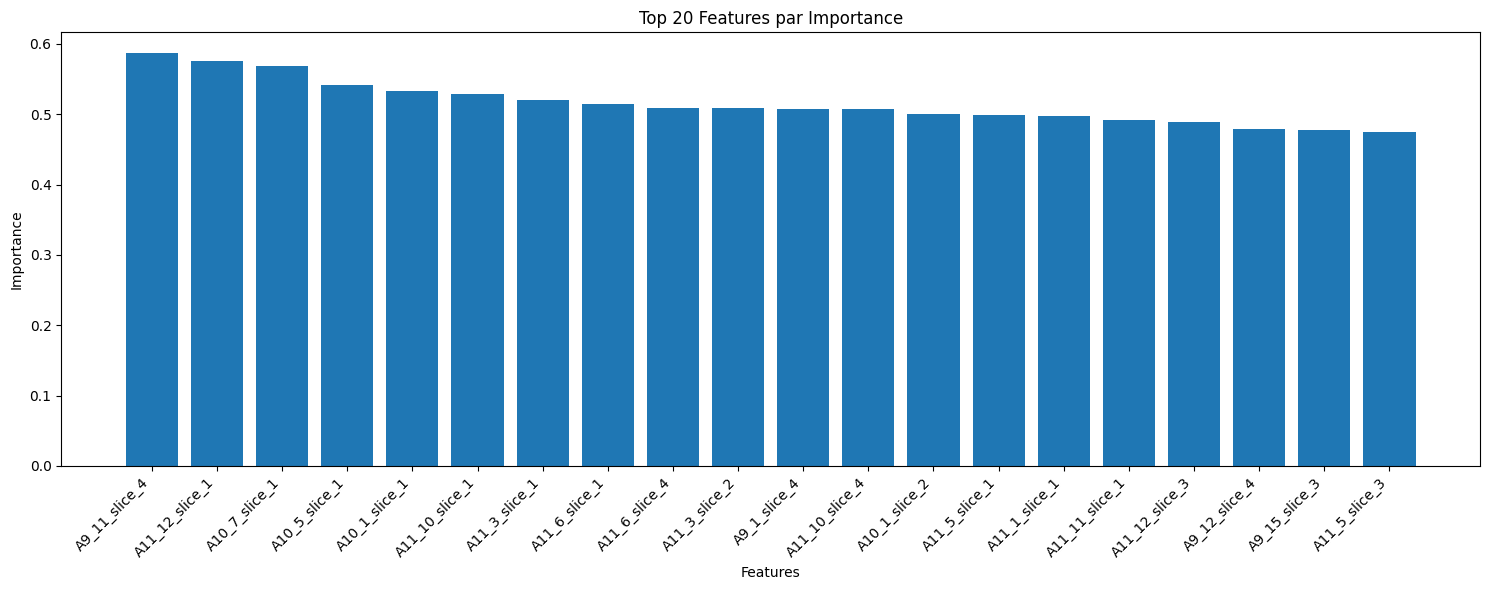

In [105]:
# Évaluation pour les données oranges
green_classification_metrics = assess_cluster_classification(dataset_orange, orange_labels)

## Analyse des sorties
Les 3 variables les plus importantes pour le groupe des variables_oranges sont : 

    A9_11_slice_4 : Le jardinage est une activité agréable, délassante

    A11_12_slice_1 : Un moyen de participer à la préservation de notre environnement (lutte contre le réchauffement climatique, préservation des abeilles et des insectes mellifères, ...)
   
    A10_7_slice_1 : Les espaces extérieurs donnent une meilleure image de vous-même


### (2) - Réaffectation avec les variables_vert (exemple)
On fait la même chose pour le clustering issu des variables vertes.

Accuracy: 95.60%
Cross-validation scores: [0.943 0.956 0.96  0.956 0.958]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       179
           1       0.97      0.99      0.98       183
           2       0.91      0.94      0.93        33
           3       0.98      0.98      0.98       285
           4       0.95      0.91      0.93        86
           5       0.95      0.92      0.93       234

    accuracy                           0.96      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.96      0.96      0.96      1000


Top 10 features:
1. C1_8_slice_5: 0.8763
2. C1_3_slice_5: 0.8311
3. C1_1_slice_5: 0.8278
4. C1_4_slice_5: 0.8068
5. C1_7_slice_5: 0.7941
6. C1_9_slice_5: 0.7842
7. C1_2_slice_5: 0.7617
8. C1_5_slice_5: 0.7470
9. C1_4_slice_4: 0.7374
10. C1_7_slice_4: 0.7232


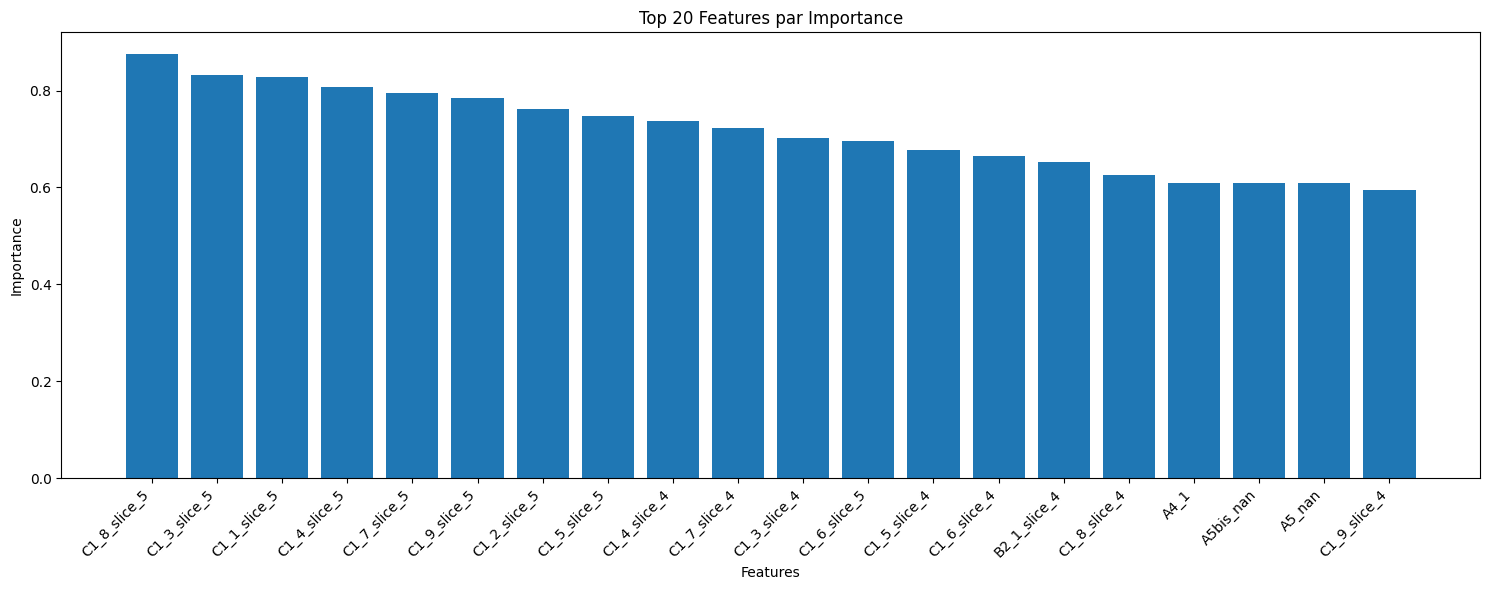

In [106]:
# Évaluation pour les données vertes
green_classification_metrics = assess_cluster_classification(dataset_green, green_labels)

## Analyse des sorties
Les 3 variables les plus importantes pour le groupe des variables_verts sont : 

    C1_8_slice_5 : Fréquence consultation sites dédiés au jardinage Des sites Internet de fabricants ou de marques de produits pour d’aménagement ou d’entretien des espaces extérieurs
   
    C1_3_slice_5 : Fréquence consultation sites dédiés au jardinage Des blogs d’expert en aménagement et entretien des espaces extérieurs    
    
    C1_1_slice_5 : Fréquence consultation sites dédiés au jardinage Des sites Internet d’enseignes de jardinerie


### 3. Réaffectation des individus dans les groupes avec variables illustratives
Dans cette partie, on teste la capacité de prédire les clusters de la segmentation “Orange” en n’utilisant que les variables “Vert” (et/ou socio) qui n’ont pas servi directement à construire la segmentation Orange (donc des variables “illustratives”).

	Et réciproquement, prédire les clusters de la segmentation “Vert” en n’utilisant que les variables “Orange” (et/ou socio).

	Ceci s’applique pour toute variable que l’on n’a pas utilisée directement dans le clustering d’origine.

### (3) - Exemple de réaffectation (variables illustratives : socio)
Dans le bloc suivant, on concatène (ou on sélectionne) les variables socio (ex. : rs3, rs5, rs6, ...) et on essaye de prédire le cluster “Orange” via un dataset “Vert + socio” (ou l’inverse).
On effectue un train/test split, on entraîne une LogisticRegression et on calcule l’accuracy.

In [151]:
def integrate_socio_demographic_analysis(features_matrix, n_components=3, n_clusters=6, use_kmeans=True):
    """
    Analyse intégrée avec réduction dimensionnelle et clustering
    
    Args:
        features_matrix: Matrice de données
        n_components: Nombre de composantes PCA
        n_clusters: Nombre de clusters
        use_kmeans: Utiliser KMeans (True) ou AgglomerativeClustering (False)
    
    Returns:
        tuple: Données PCA, labels de clustering
    """
    # Réduction de dimensionnalité
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(features_matrix)
    
    # Clustering
    if use_kmeans:
        clustering = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    else:
        clustering = AgglomerativeClustering(n_clusters=n_clusters)
    
    cluster_labels = clustering.fit_predict(pca_data)
    
    return pca_data, cluster_labels

def cross_cluster_prediction(source_data, target_labels, test_size=0.4, random_state=42, color_matrix='Greens'):
    """
    Prédiction croisée des clusters
    """
    X_train, X_test, y_train, y_test = train_test_split(
        source_data, target_labels,
        test_size=test_size,
        random_state=random_state
    )
    
    lr = LogisticRegression(random_state=random_state, max_iter=1000)
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_matrix)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    print(f"Précision prédictive: {accuracy:.4f}")
    return accuracy, X_train, X_test, y_train, y_test, predictions


Prédiction cluster (oranges) via verts - LogisticRegression:


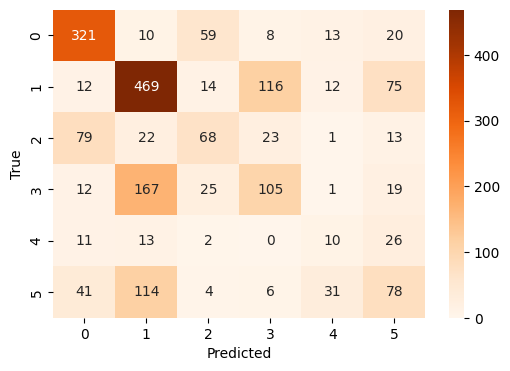

Précision prédictive: 0.5255


In [156]:
# Application sur les données orange avec KMeans
orange_pca, labels_orange = integrate_socio_demographic_analysis(
    dataset_orange_socio, 
    use_kmeans=True
)

# Prédiction des clusters oranges à partir des verts
print("Prédiction cluster (oranges) via verts - LogisticRegression:")
acc_green_to_orange, _, _, _, _, _ = cross_cluster_prediction(
    dataset_green_socio,
    labels_orange,
    color_matrix='Oranges'
)


Prédiction cluster (verts) via oranges - LogisticRegression:


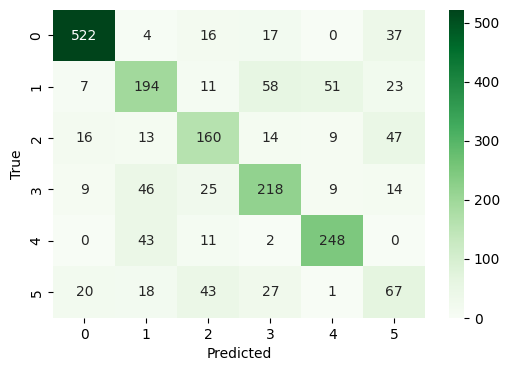

Précision prédictive: 0.7045


In [157]:
# Application sur les données vertes avec AgglomerativeClustering
green_pca, labels_green = integrate_socio_demographic_analysis(
    dataset_green_socio, 
    use_kmeans=False,
)

# Prédiction des clusters verts à partir des oranges
print("\nPrédiction cluster (verts) via oranges - LogisticRegression:")
acc_orange_to_green, _, _, _, _, _ = cross_cluster_prediction(
    dataset_orange_socio,
    labels_green,
    color_matrix='Greens'
)


Analyse des résultats :
	
    •	accuracy_1 ~ 0.52 ou tout autre valeur : Capacité de prédire la segmentation Orange juste avec les variables Vert + socio.
	•	accuracy_2 ~ 0.70 : Meilleure performance pour prédire la segmentation Vert via les variables Orange + socio.
	•	Les matrices de confusion montrent les clusters souvent confondus.



## Conclusion 

Dans ce notebook, nous avons :
	
Réalisé deux segmentations (clustering) :
	
    •	Segmentation Orange (A9, A10, A11).
	•	Segmentation Vert (A11, A12, A13, A14, A4, A5, A5bis, …).
	•	Nous avons justifié le nombre de clusters (par exemple, 6) en observant le coefficient de silhouette et la répartition.
    
Réaffecté les individus (sur un échantillon test) en utilisant les variables actives (celles ayant servi au clustering), via un algorithme de classification (ici, Régression Logistique):

	•	Nous avons observé une précision souvent > 90%.
	•	On peut identifier un sous-ensemble minimal de variables “Golden Questions” pour maintenir une précision élevée.
Réaffecté les individus avec des variables illustratives (non utilisées dans la segmentation initiale), afin de tester la capacité de classification:
	
    •	Par exemple, pour la segmentation Orange, on utilise les variables Vert ou socio.
	•	Les résultats peuvent être plus faibles (ex. 50-65% de précision), ce qui signifie que ces variables illustratives n’expliquent pas pleinement la segmentation initiale.